# アンテナログから$Az, El$と追尾誤差の時間変動のプロットを作成

国立極地研究所 低温試験で使用

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import datetime
import matplotlib as mpl
from scipy.optimize import curve_fit
import matplotlib.dates as mdates

mpl.rcParams.update({'axes.grid': True})
mpl.rcParams.update({'grid.linestyle': ':'})
mpl.rcParams.update({'font.size': 16})

アンテナログ読み込み

In [2]:
data = pd.read_csv(r"log/azel-20241202133505.log", header=None)

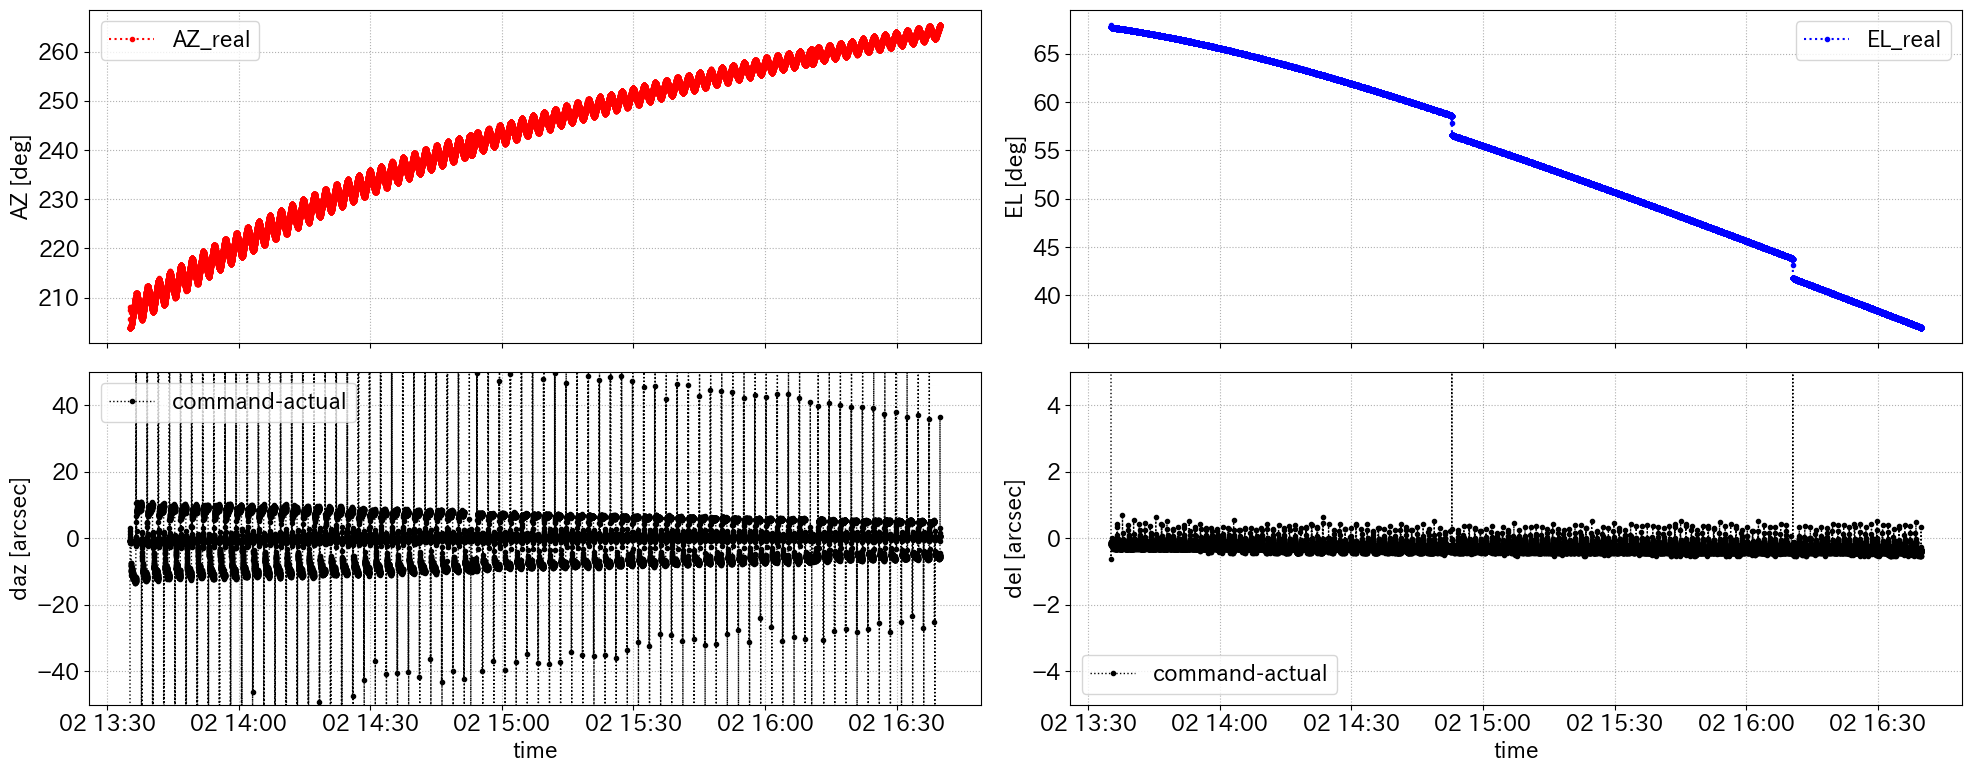

In [3]:
# 全体
def parse_date(date_str):
    return datetime.datetime.strptime(date_str[1:24], '%Y/%m/%d-%H:%M:%S.%f')

data[0] = data[0].apply(parse_date)

x_values = data[0] 
az_real = data[6]
el_real = data[7]
az_cmd = data[8]
el_cmd = data[9]
e_load_az = data[10]    # AZ実効負荷率[%]
e_load_el = data[11]   # EL実効負荷率[%]

fig,ax = plt.subplots(figsize=(20,8),nrows=2,ncols=2,sharex=True)
plt.rcParams["font.size"] = 16

ax[0][0].plot(x_values,az_real,':.r',label='AZ_real')
ax[0][0].set_ylabel('AZ [deg]')
#ax[0][0].set_ylim(145, 158)
ax[0][0].legend()

ax[0][1].plot(x_values,el_real,':.b',label='EL_real')
ax[0][1].set_ylabel('EL [deg]')
ax[0][1].legend()

ax[1][0].plot(x_values,(az_cmd-az_real)*3600,marker=".", ls=":",color="black",lw=1,label='command-actual')
ax[1][0].set_ylabel('daz [arcsec]')
ax[1][0].set_xlabel('time')
ax[1][0].tick_params(axis='x', rotation=0)
#ax[1][0].set_xlim(datetime.datetime(2024,8,7,11,0,30),datetime.datetime(2024,8,7,11,6,0))
ax[1][0].set_ylim(-50,50)
#ax[0][1].set_title('azimuth 負荷率')
ax[1][0].legend()

ax[1][1].plot(x_values,(el_real-el_cmd)*3600,marker=".", ls=":",color="black",lw=1,label='command-actual')
ax[1][1].set_ylabel('del [arcsec]')
ax[1][1].set_xlabel('time')
ax[1][1].tick_params(axis='x', rotation=0)
ax[1][1].set_ylim(-5,5)
#ax[0][1].set_title('elevation 負荷率')
ax[1][1].legend()

fig.tight_layout()
#fig.savefig(dict_azel['fn']+'_azel.png')

Az vs EL Plot

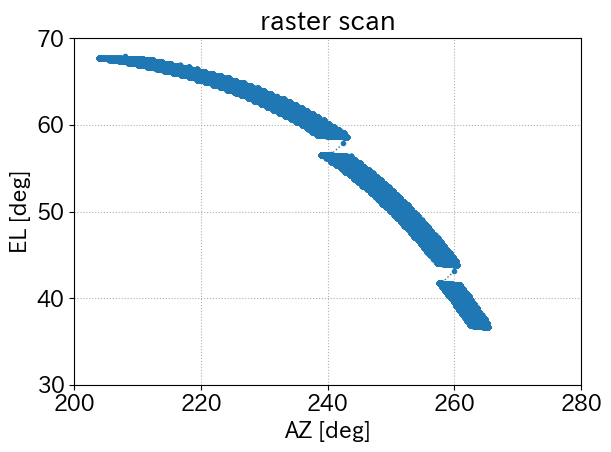

In [6]:
# 観測テーブルのAZ, ELのプロット
plt.plot(az_real, el_real,marker=".", ls = ":", lw = 1)
plt.xlabel("AZ [deg]")
plt.ylabel("EL [deg]")
plt.xlim(200,280)
plt.ylim(30,70)
plt.title("raster scan")
plt.xticks(rotation=0)  
plt.tight_layout()  
plt.show()

### ヒストグラム　複数のピークにガウシアンフィット

AZ_error [arcsec]
1つ目のピーク: 振幅 (a1) = 3764.9725064991153, 平均 (mu1) = -7.55980216561643, 標準偏差 (sigma1) = 2.0806825671095175, FWHM = 4.899633016375946
2つ目のピーク: 振幅 (a2) = 2914.205659534651, 平均 (mu2) = 0.15498526321885783, 標準偏差 (sigma2) = 0.7791092658362279, FWHM = 1.834662116460496
3つ目のピーク: 振幅 (a3) = 4980.487089753044, 平均 (mu3) = 6.618388451377609, 標準偏差 (sigma3) = 1.5094219717471038, FWHM = 3.554417115480219
-------------------------------------------
EL_error [arcsec]
振幅 (a): 13392.850810192154, 平均 (mu): 0.3123417173399142, 標準偏差 (sigma): 0.08500665914150167, FWHM: 0.20017538490752151


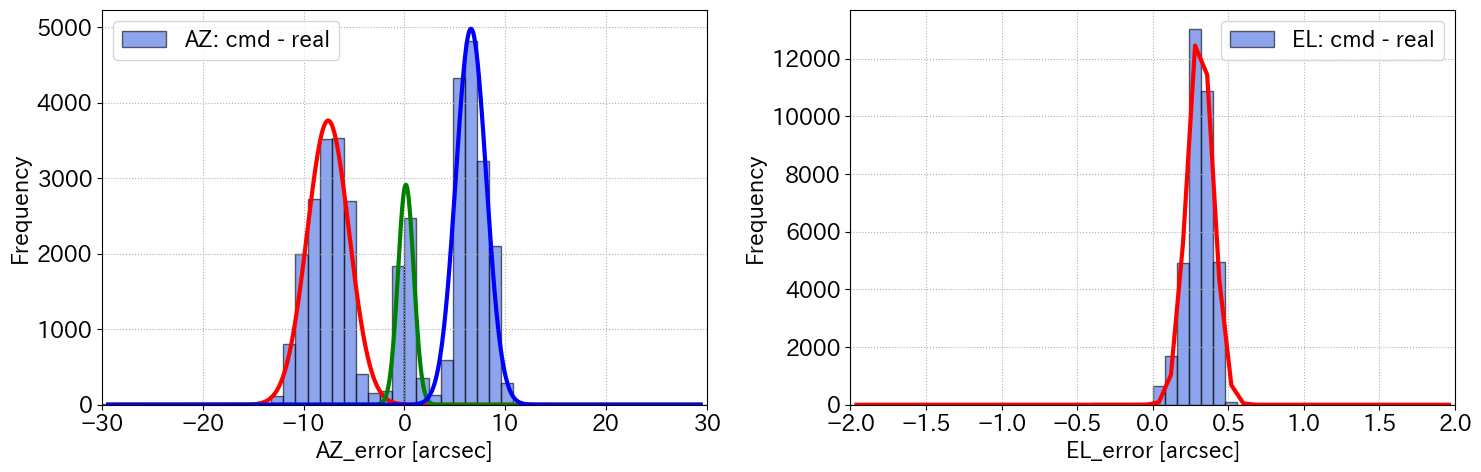

In [11]:
az_cmd = data[8]
az_real = data[6]

az_error = (az_cmd - az_real) * 3600
el_error = (el_cmd - el_real) * 3600  

hist, bins = np.histogram(az_error, bins=50, range=(-30, 30))
hist_2, bins_2 = np.histogram(el_error, bins=50, range=(-2, 2))  
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers_2 = (bins_2[:-1] + bins_2[1:]) / 2  # ビンの中心

def triple_gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2, a3, mu3, sigma3):
    gauss1 = a1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    gauss2 = a2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
    gauss3 = a3 * np.exp(-(x - mu3)**2 / (2 * sigma3**2))
    return gauss1 + gauss2 + gauss3

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

# フィットの初期パラメータ (振幅、平均、標準偏差)
initial_params = [3500, -10, 2, 2200, 0, 2, 5000, 6, 2]
initial_params_2 = [12000, 0.3, 0.1] 

# ガウシアンフィットの境界条件を設定
lower_bounds = [0, -np.inf, 0,  # a1, mu1, sigma1 の下限
                0, -np.inf, 0,  # a2, mu2, sigma2 の下限
                0, -np.inf, 0]  # a3, mu3, sigma3 の下限

upper_bounds = [np.inf, np.inf, np.inf,  # a1, mu1, sigma1 の上限
                np.inf, np.inf, np.inf,  # a2, mu2, sigma2 の上限
                np.inf, np.inf, np.inf]  # a3, mu3, sigma3 の上限

lower_bounds_2 = [0, -np.inf, 0]  # a, mu, sigma の下限
upper_bounds_2 = [np.inf, np.inf, np.inf]  # a, mu, sigma の上限

popt, pcov = curve_fit(
    triple_gaussian, bin_centers, hist, 
    p0=initial_params, bounds=(lower_bounds, upper_bounds)
)

popt_2, pcov_2 = curve_fit(
    gaussian, bin_centers_2, hist_2, 
    p0=initial_params_2, bounds=(lower_bounds_2, upper_bounds_2)
)

a1, mu1, sigma1, a2, mu2, sigma2, a3, mu3, sigma3 = popt
fwhm1 = 2 * np.sqrt(2 * np.log(2)) * sigma1  # 1つ目のピークのFWHM
fwhm2 = 2 * np.sqrt(2 * np.log(2)) * sigma2  # 2つ目のピークのFWHM
fwhm3 = 2 * np.sqrt(2 * np.log(2)) * sigma3  # 3つ目のピークのFWHM

a, mu, sigma = popt_2
fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma  # FWHMの計算
fit_y = gaussian(bin_centers_2, *popt_2)

print("AZ_error [arcsec]")
print(f"1つ目のピーク: 振幅 (a1) = {a1}, 平均 (mu1) = {mu1}, 標準偏差 (sigma1) = {sigma1}, FWHM = {fwhm1}")
print(f"2つ目のピーク: 振幅 (a2) = {a2}, 平均 (mu2) = {mu2}, 標準偏差 (sigma2) = {sigma2}, FWHM = {fwhm2}")
print(f"3つ目のピーク: 振幅 (a3) = {a3}, 平均 (mu3) = {mu3}, 標準偏差 (sigma3) = {sigma3}, FWHM = {fwhm3}")

print("-------------------------------------------")
print("EL_error [arcsec]")
print(f"振幅 (a): {a}, 平均 (mu): {mu}, 標準偏差 (sigma): {sigma}, FWHM: {fwhm}")


x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
y1 = a1 * np.exp(-(x_fit - mu1)**2 / (2 * sigma1**2))
y2 = a2 * np.exp(-(x_fit - mu2)**2 / (2 * sigma2**2))
y3 = a3 * np.exp(-(x_fit - mu3)**2 / (2 * sigma3**2))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(az_error, bins=bins, alpha=0.6, color="royalblue", edgecolor='black', label='AZ: cmd - real')
ax[0].plot(x_fit, y1, color="r", linewidth=3)
ax[0].plot(x_fit, y2, color="g", linewidth=3)
ax[0].plot(x_fit, y3, color="b", linewidth=3)
ax[0].set_xlabel("AZ_error [arcsec]")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(-30, 30)
ax[0].legend()
ax[0].grid(True)

ax[1].hist(el_error, bins=bins_2, alpha=0.6, color='royalblue', edgecolor='black', label='EL: cmd - real')
ax[1].plot(bin_centers_2, fit_y, 'r', linewidth=3)
ax[1].set_xlabel("EL_error [arcsec]")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(-2, 2)
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


### まとめてプロット

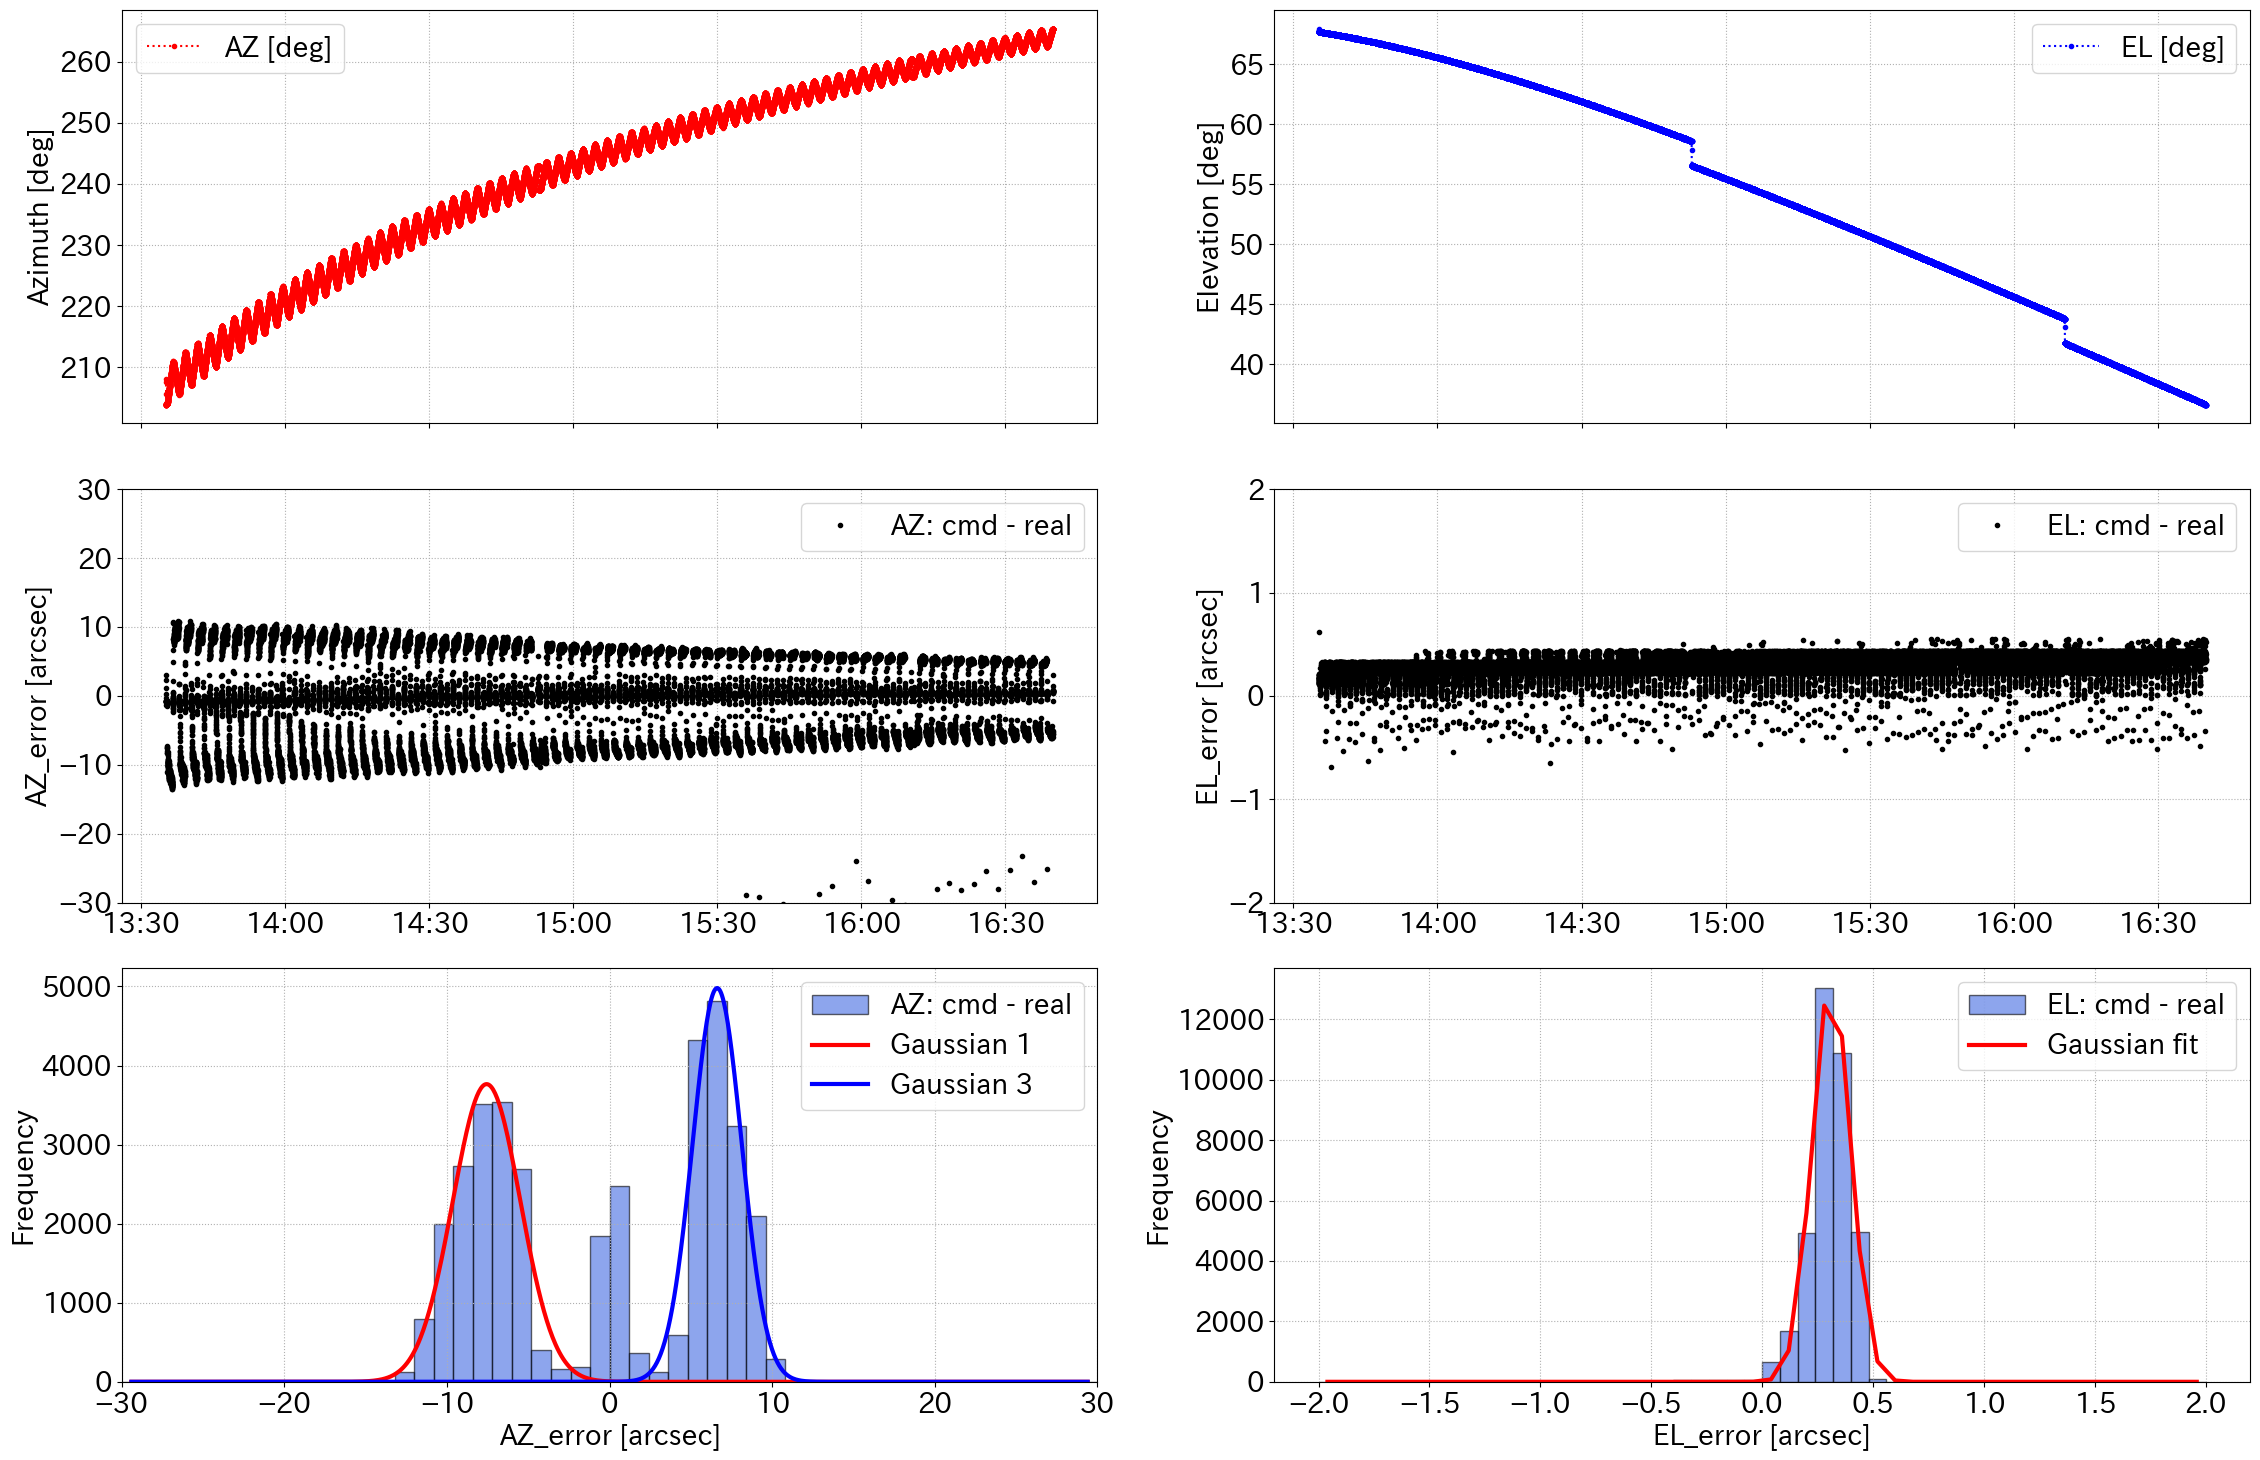

In [22]:
mpl.rcParams.update({'font.size': 20})

data = pd.read_csv(r"log/azel-20241202133505.log", header=None)

def parse_date(date_str):
    return datetime.datetime.strptime(date_str[1:24], '%Y/%m/%d-%H:%M:%S.%f')

data[0] = data[0].apply(parse_date)

x_values = data[0] 
az_real = data[6]
el_real = data[7]
az_cmd = data[8]
el_cmd = data[9]

az_error = (az_cmd - az_real) * 3600
el_error = (el_cmd - el_real) * 3600  

hist, bins = np.histogram(az_error, bins=50, range=(-30, 30))
hist_2, bins_2 = np.histogram(el_error, bins=50, range=(-2, 2))  
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers_2 = (bins_2[:-1] + bins_2[1:]) / 2

x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
y1 = a1 * np.exp(-(x_fit - mu1)**2 / (2 * sigma1**2))  # 1つ目のガウシアン
y2 = a2 * np.exp(-(x_fit - mu2)**2 / (2 * sigma2**2))  # 2つ目のガウシアン
y3 = a3 * np.exp(-(x_fit - mu3)**2 / (2 * sigma3**2))  # 3つ目のガウシアン

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[np.max(hist), 0, 1])
popt_2, _ = curve_fit(gaussian, bin_centers_2, hist_2, p0=[np.max(hist_2), 0, 1])

fit_y1 = gaussian(bin_centers, *popt)
fit_y2 = gaussian(bin_centers_2, *popt_2)


fig, ax = plt.subplots(3, 2, figsize=(23, 15))

ax[0, 0].plot(x_values, az_real, ':.r', label='AZ [deg]')
ax[0, 0].xaxis.set_tick_params(labelbottom=False)  
ax[0, 0].set_ylabel('Azimuth [deg]')
#ax[0, 0].set_ylim(150, 200)
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[0, 1].plot(x_values, el_real, ':.b', label='EL [deg]')
ax[0, 1].xaxis.set_tick_params(labelbottom=False)  
ax[0, 1].set_ylabel('Elevation [deg]')
#ax[0, 1].set_ylim(62, 67)
ax[0, 1].legend()
ax[0, 1].grid(True)

ax[1, 0].plot(x_values, az_error, 'k.', label='AZ: cmd - real')
ax[1, 0].tick_params(axis='x', rotation=0)
ax[1, 0].set_ylabel('AZ_error [arcsec]')
ax[1, 0].set_ylim(-30, 30)
ax[1, 0].legend()
ax[1, 0].grid(True)

ax[1, 1].plot(x_values, el_error, 'k.', label='EL: cmd - real')
ax[1, 1].tick_params(axis='x', rotation=0)
ax[1, 1].set_ylabel('EL_error [arcsec]')
ax[1, 1].set_ylim(-2, 2)
ax[1, 1].legend()
ax[1, 1].grid(True)

ax[2, 0].hist(az_error, bins=bins, alpha=0.6, color="royalblue", edgecolor='black', label='AZ: cmd - real')
ax[2, 0].plot(x_fit, y1, "r-", linewidth=3, label=fr'Gaussian 1')
#ax[2, 0].plot(x_fit, y2, "g-", linewidth=3, label=fr'Gaussian 2 ')
ax[2, 0].plot(x_fit, y3, "b-", linewidth=3, label=fr'Gaussian 3')
ax[2, 0].set_xlabel("AZ_error [arcsec]")
ax[2, 0].set_ylabel("Frequency")
ax[2, 0].set_xlim(-30, 30)
ax[2, 0].legend()
ax[2, 0].grid(True)

ax[2, 1].hist(el_error, bins=bins_2, alpha=0.6, color='royalblue', edgecolor='black', label='EL: cmd - real')
ax[2, 1].plot(bin_centers_2, fit_y2, 'r-', linewidth=3, label='Gaussian fit')
ax[2, 1].set_xlabel("EL_error [arcsec]")
ax[2, 1].set_ylabel("Frequency")
ax[2, 1].legend()
ax[2, 1].grid(True)

# 最初の2行のみでx軸を共有
time_format = mdates.DateFormatter("%H:%M")
for i in range(2):
    for j in range(2):
        ax[i, j].xaxis.set_major_formatter(time_format)

# プロットのレイアウト調整と表示
plt.tight_layout()
plt.show()
